In [1]:
import csv
import cv2
import numpy as np
import sklearn
import random
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model
from keras.layers import Flatten, Dense, Lambda, Dropout, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pyplot import imshow

Using TensorFlow backend.


In [2]:
def generator(samples, batch_size=32):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        random.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            
            for batch_sample in batch_samples:
                # create adjusted steering measurements for the side camera images
                correction = 0.2 # this is a parameter to tune
                angle = [float(batch_sample[3])]
                angle.append(angle[0] + correction)
                angle.append(angle[0] - correction)
                
                # read in images from center, left and right cameras
                for i in range(3):
                    name = '../data/IMG/'+batch_sample[i].split('/')[-1]
                    # It is too slow to use PIL to read images in generator, I use cv2 and switch the BGR to RGB
                    image = cv2.imread(name)
                    """
                    Convert BGR to RGB
                    http://www.bogotobogo.com/python/OpenCV_Python/python_opencv3_matplotlib_rgb_brg_image_load_display_save.php
                    """
                    b,g,r = cv2.split(image)       # get b,g,r
                    image = cv2.merge([r,g,b])     # switch it to rgb
                    images.append(image)
                    angles.append(angle[i])
                    """
                    To avoid the agent driving the car on the left side of the center line in Track Two,
                    the flip image augmentation is not used.
                    """

            # add images and angles to data set
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [3]:
samples = []

"""
Load Sample Training Data, 8000+ images
"""
with open('../data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

"""
Load New Training Data, 4000+ inmages, 2 laps of Tracks 1 in clockwise direction 
and 2 laps of Tracks 1 in counter-clockwise direction
"""
with open('../new1/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)

"""
Load New Training Data, 1 lap of Track 2 in clockwise direction
"""
with open('../new2/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
"""
Load New Training Data, 1 lap of Track 2 in clockwise direction
"""
with open('../new3/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)
        
        
"""
Load New Training Data, 1 lap of Track 2 in counter-clockwise direction
"""
with open('../new4/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)        
        
"""
Load New Training Data, 1 lap of Track 2 in counter-clockwise direction
"""
with open('../new5/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)        
        
        
print('Total samples: {}'.format(len(samples)))

Total samples: 26345


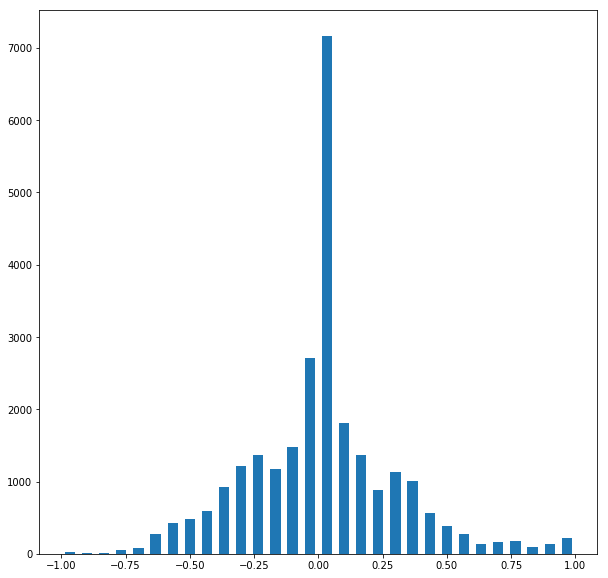

In [4]:
"""
Data visualization of the steering angles in training data.
There are too much training data with steering angle near 0,
whicle too little training data with steering angle less than -0.65 and larger than 0.65.
"""
out = []
for sample in samples[1:]:
    out.append(float(sample[3]))
plt.figure(figsize=(10,10))
plt.hist(out,bins=30, rwidth = 0.6)
plt.show()

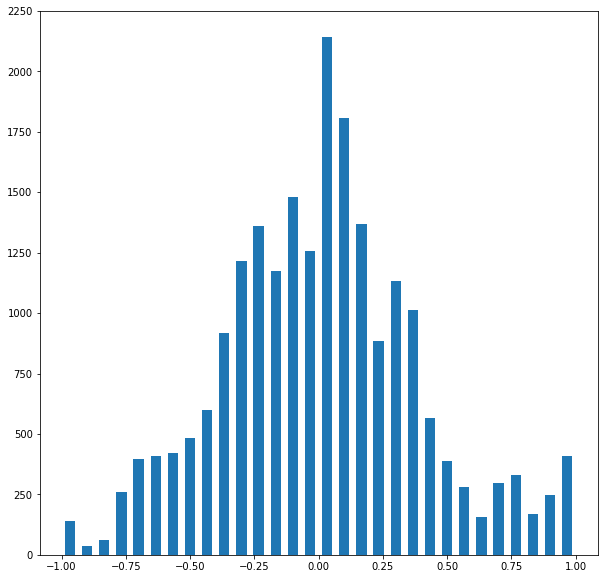

Total new samples: 21404


In [5]:
"""
Downsampling the training data with steering angle near 0,
Upsampling the training data with steering angle less than -0.65 and larger than 0.65.
"""
out1 = []
new_samples = []
for sample in samples[1:]:
    tmp = float(sample[3])
    if tmp > -0.04 and tmp < 0.04:
        if random.random() < 0.2:
            out1.append(float(sample[3]))
            new_samples.append(sample)
    elif tmp < -0.65:
        out1.append(float(sample[3]))
        new_samples.append(sample)
        if random.random() < 0.9:
            out1.append(float(sample[3]))
            new_samples.append(sample)
        if random.random() < 0.9:
            out1.append(float(sample[3]))
            new_samples.append(sample)
        if random.random() < 0.9:
            out1.append(float(sample[3]))
            new_samples.append(sample)
        if random.random() < 0.9:
            out1.append(float(sample[3]))
            new_samples.append(sample)
    elif tmp > 0.65:
        out1.append(float(sample[3]))
        new_samples.append(sample)
        if random.random() < 0.9:
            out1.append(float(sample[3]))
            new_samples.append(sample)
    else:
        out1.append(float(sample[3]))
        new_samples.append(sample)
plt.figure(figsize=(10,10))
plt.hist(out1,bins=30, rwidth = 0.6)
plt.show()
print('Total new samples: {}'.format(len(new_samples)))

In [6]:
train_samples, validation_samples = train_test_split(new_samples, test_size=0.2)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

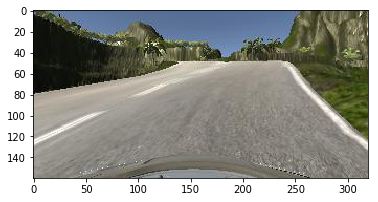

In [7]:
# show a sample image
name = '../data/IMG/'+train_samples[0][0].split('/')[-1]
image = cv2.imread(name)
b,g,r = cv2.split(image)       # get b,g,r
image = cv2.merge([r,g,b])     # switch it to rgb
imshow(image)

In [8]:
model = Sequential()

# Input planes 3@160x320
# Cropping images, trim image to only see section with road
# Cropped planes 3@85x320
model.add(Cropping2D(cropping=((50,25),(0,0)), input_shape=(160,320,3)))

# Normalized input planes
model.add(Lambda(lambda x: x / 255.0 - 0.5))

# Convolutional feature map 36@41x158
model.add(Convolution2D(36,5,5,subsample=(2,2),activation='relu',W_regularizer=l2(0.001)))
model.add(Dropout(0.2))

# Convolutional feature map 48@19x77
model.add(Convolution2D(48,5,5,subsample=(2,2),activation='relu',W_regularizer=l2(0.001)))
model.add(Dropout(0.2))

# Convolutional feature map 72@8x37
model.add(Convolution2D(72,5,5,subsample=(2,2),activation='relu',W_regularizer=l2(0.001)))
model.add(Dropout(0.2))

# Convolutional feature map 100@6x35
model.add(Convolution2D(100,3,3,activation='relu',W_regularizer=l2(0.001)))
model.add(Dropout(0.2))

# Convolutional feature map 100@4x33
model.add(Convolution2D(100,3,3,activation='relu',W_regularizer=l2(0.001)))
model.add(Dropout(0.2))

# Fully-connected layer, 13200 neurons
model.add(Flatten())
model.add(Dropout(0.2))

# Fully-connected layer, 100 neurons
model.add(Dense(100,W_regularizer=l2(0.001)))
model.add(Dropout(0.2))

# Fully-connected layer, 50 neurons
model.add(Dense(50,W_regularizer=l2(0.001)))
model.add(Dropout(0.2))

# Fully-connected layer, 10 neurons
model.add(Dense(10,W_regularizer=l2(0.001)))
model.add(Dropout(0.2))

# Output: vehicle control
model.add(Dense(1))

Epoch 1/20
51369/51369 [==============================] - 207s - loss: 0.1865 - val_loss: 0.0846
Epoch 2/20
51369/51369 [==============================] - 204s - loss: 0.0777 - val_loss: 0.0717
Epoch 3/20
51369/51369 [==============================] - 204s - loss: 0.0666 - val_loss: 0.0700
Epoch 4/20
51369/51369 [==============================] - 204s - loss: 0.0651 - val_loss: 0.0551
Epoch 5/20
51369/51369 [==============================] - 204s - loss: 0.0613 - val_loss: 0.0512
Epoch 6/20
51369/51369 [==============================] - 203s - loss: 0.0605 - val_loss: 0.0580
Epoch 7/20
51369/51369 [==============================] - 203s - loss: 0.0597 - val_loss: 0.0592
Epoch 8/20
51369/51369 [==============================] - 204s - loss: 0.0597 - val_loss: 0.0539
Epoch 9/20
51369/51369 [==============================] - 204s - loss: 0.0586 - val_loss: 0.0600
dict_keys(['val_loss', 'loss'])


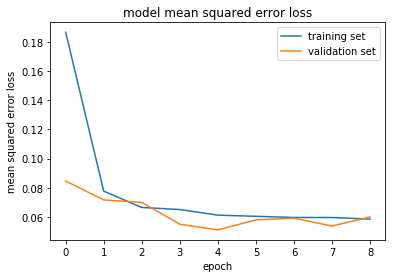

In [9]:
model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, 
                                     # augmentation data with center/left/right, resulting 3 times.
                                     samples_per_epoch =len(train_samples)*3, 
                                     validation_data = validation_generator,
                                     # augmentation data with center/left/right, resulting 3 times.
                                     nb_val_samples = len(validation_samples)*3, 
                                     nb_epoch=20, verbose=1,
                                     callbacks=[
                                         # Stop training when validation loss has stopped improving for 3 epochs.
                                         EarlyStopping(monitor='val_loss',
                                                       patience=3, verbose=0, mode='auto'),
                                         # Save the model when the validation loss is the smallest.
                                         ModelCheckpoint(filepath='../model.h5',
                                                         monitor='val_loss',
                                                         verbose=0,
                                                         save_best_only=True, mode='auto')
                                                ])

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()